In [12]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("Dataset.csv")

# Data overview
print(df.head())

# Separate features and target variable
features = df.drop(columns=["DEATH_EVENT"])
target = df["DEATH_EVENT"]

# Standardize features
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

In [13]:
# Convert continuous features to boolean data
bool_features = features_scaled.apply(lambda x: x > x.mean(), axis=0)

# Display boolean data
print("\n[Boolean Dataset]:")
print(bool_features.head())


[Boolean Dataset]:
     age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0   True    False                      True     False              False   
1  False    False                      True     False              False   
2   True    False                     False     False              False   
3  False     True                     False     False              False   
4   True     True                     False      True              False   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium    sex  \
0                 True       True              True         False   True   
1                False       True             False         False   True   
2                False      False             False         False   True   
3                False      False              True          True   True   
4                False       True              True         False  False   

   smoking   time  
0    False  False  
1    False  False  
2     

In [14]:
# Convert the boolean dataset to transaction format
transactions = []
for index, row in bool_features.iterrows():
    transaction = [col for col in bool_features.columns if row[col]]
    transactions.append(transaction)

# Print the first 5 transactions
print("\nTransaction data example:")
for i, transaction in enumerate(transactions[:5]):
    print(f"affairs {i+1}: {transaction}")


Transaction data example:
affairs 1: ['age', 'creatinine_phosphokinase', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'sex']
affairs 2: ['creatinine_phosphokinase', 'platelets', 'sex']
affairs 3: ['age', 'sex', 'smoking']
affairs 4: ['anaemia', 'serum_creatinine', 'serum_sodium', 'sex']
affairs 5: ['age', 'anaemia', 'diabetes', 'platelets', 'serum_creatinine']


In [15]:
from itertools import combinations
from collections import defaultdict
import pandas as pd

# Assume thhat 'target' is the target condition (DEATH_EVENT)
# True indicates that the target event has occurred
bool_target = target == 1

# Remove the feature combinations of 'time', 'sex', and 'age'
transactions_filtered = []
for index, transaction in enumerate(transactions):
    filtered_transaction = [item for item in transaction if item not in ["time", "sex", "age"]]
    transactions_filtered.append((filtered_transaction, bool_target.iloc[index]))

# Calculate the confidence value
comb_confidence_counts = defaultdict(lambda: {"occurrences": 0, "target_occurrences": 0})

# For each transaction, count the occurrence of each combination and the number of target events
for transaction, target_value in transactions_filtered:
    for comb in combinations(transaction, 2):
        comb_confidence_counts[comb]["occurrences"] += 1
        if target_value:
            comb_confidence_counts[comb]["target_occurrences"] += 1

# Filter combinations with high confidence
min_confidence = 0.4  # Minimum confidence（40%）
filtered_comb_confidences = {
    k: v["target_occurrences"] / v["occurrences"]
    for k, v in comb_confidence_counts.items()
    if v["target_occurrences"] / v["occurrences"] >= min_confidence
}

# Convert to DataFrame format
filtered_comb_confidences_df = pd.DataFrame(
    list(filtered_comb_confidences.items()),
    columns=["Feature Combination", "Confidence"]
).sort_values(by="Confidence", ascending=False)

# Print the table
print("\nHigh-confidence feature combinations:")
print(filtered_comb_confidences_df)


High-confidence feature combinations:
                            Feature Combination  Confidence
1       (high_blood_pressure, serum_creatinine)    0.791667
3                   (anaemia, serum_creatinine)    0.611111
5                  (diabetes, serum_creatinine)    0.593750
2                 (platelets, serum_creatinine)    0.558140
0  (creatinine_phosphokinase, serum_creatinine)    0.551724
8                   (serum_creatinine, smoking)    0.478261
6         (ejection_fraction, serum_creatinine)    0.476190
7                (high_blood_pressure, smoking)    0.466667
4              (serum_creatinine, serum_sodium)    0.440000
9                           (diabetes, smoking)    0.400000


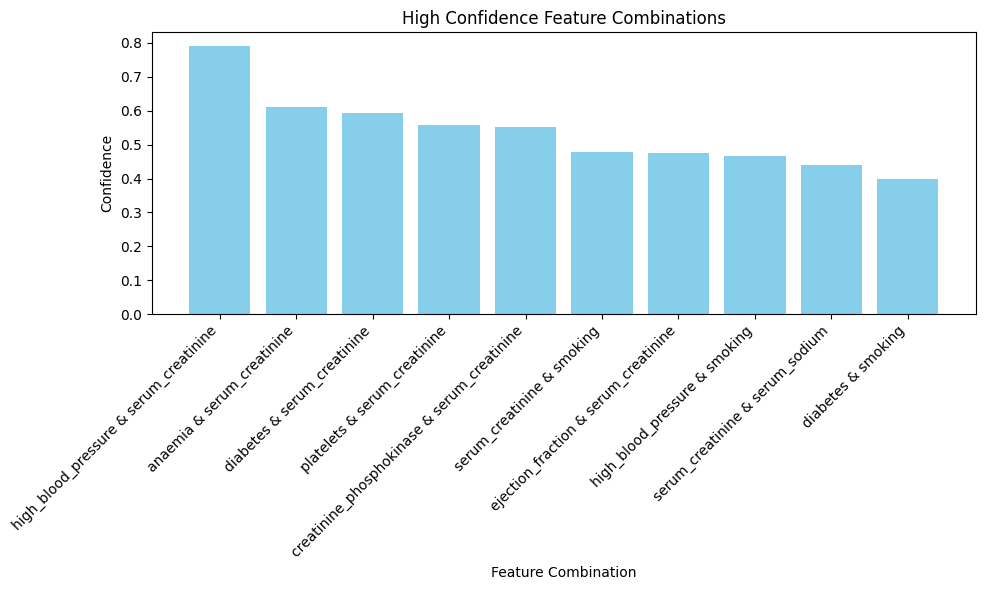

In [16]:
import matplotlib.pyplot as plt

# Convert to DataFrame format and sort
filtered_comb_confidences_df = pd.DataFrame(
    list(filtered_comb_confidences.items()),
    columns=["Feature Combination", "Confidence"]
).sort_values(by="Confidence", ascending=False)

# Visualize confidence levels
plt.figure(figsize=(10, 6))
plt.bar(
    [" & ".join(comb) for comb in filtered_comb_confidences_df["Feature Combination"]],
    filtered_comb_confidences_df["Confidence"],
    color="skyblue"
)
plt.title("High Confidence Feature Combinations")
plt.xlabel("Feature Combination")
plt.ylabel("Confidence")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()